# Pipeline for Full-Frame Images
1. Convert the cutout into a lightcurve
2. Make a river plot of the lightcurve and draw a line at the extrema
3. Produce a Lomb-Scargle periodogram and label the harmonics

## Setup and Imports
This cell imports all of the necessary libraries. It also sets up two important variables: `DOWNLOAD_PATH` and `LIGHTCURVE_PATH`, where the cutouts are downloaded and the lightcurves are stored. On Colab, these need to be changed.

In [1]:
import os
import json
import random
import tess_cpm
import numpy as np
import pandas as pd
import lightkurve as lk

import matplotlib
import matplotlib.pyplot as plt

from astropy import table
from astropy import units as u
from scipy.signal import find_peaks
from astroquery.mast import Tesscut
from astroquery.mast.utils import parse_input_location

from collections import OrderedDict

%matplotlib inline

DOWNLOAD_PATH = "./data"
LIGHTCURVE_PATH = "./lightcurves"
PROCVER = "v0.3.1"

## Downloading and Processing Images

This cell contains the code to download a TESS cutout and process it with `tess-cpm`. The resulting lightcurve is saved to a CSV. The name of the folder in which the lightcurve is saved is its TIC, and the filename is the sector number. 

**`download_object(coordinates=None, size=50, sector=None, inflate=True, objectname=None)`**

Downloads a cutout for a given sector and returns the path. If the cutout has already been downloaded, only returns the path.

**`process_sector(tic, sector)`**

Generates a lightcurve from a full-frame image of the object with the given TIC during the given sector. Saves the lightcurve to a CSV and returns it.

**`load_lc(tic, sector)`**

Loads the lightcurve of the given object and sector. Downloads and processes the FFI for the sector if it does not already exist.

**`load_lcs(tic, sectors)`**

Loads several sectors for the given tic into one combined lightcurve. `sectors` should be a list of integers.


In [11]:
def download_object(coordinates=None, size=50, sector=None, inflate=True, objectname=None):
    print(f"Downloading {objectname}:{sector}")
    coords = parse_input_location(coordinates, objectname)
    ra = f"{coords.ra.value:.6f}"

    path = Tesscut.download_cutouts(coordinates=coordinates, size=size, sector=sector, path=DOWNLOAD_PATH, inflate=inflate, objectname=objectname)
    return [path[0]["Local Path"]]

def get_cycle(sector):
    cycles = [(1, 13), (14, 26), (27, 39), (40, 55), (56, 69), (70, 83), (83, 96)]
    for i, cycle in enumerate(cycles):
        if sector in range(cycle[0], cycle[1] + 1):
            return i + 1

def process_sector(tic, sector):
    """
    Create a lightcurve for a given TIC and sector. Save it as a CSV.
    """

    # If the lightcurve already exists, do nothing.
    if os.path.isfile(f"{LIGHTCURVE_PATH}/{tic.split()[1]}/Sector{sector}.csv"):
        return

    # Download the full-frame images from TESScut and run TESS-CPM.
    file = download_object(objectname=tic, sector=sector)
    s = tess_cpm.Source(f"{file[0]}", remove_bad=True)
    
    s.set_aperture(rowlims=[25, 25], collims=[25, 25])
    s.add_cpm_model(exclusion_size=5, n=64, predictor_method="similar_brightness")

    s.set_regs([0.1])
    s.holdout_fit_predict(k=100)

    apt_detrended_flux = s.get_aperture_lc(data_type="cpm_subtracted_flux")

    # Create the LightCurve object from the time and flux returned by TESS-CPM
    lc = lk.LightCurve(time=s.time, flux=apt_detrended_flux)

    # Fill the LightCurve object's metadata dictionary.
    lc.meta["SECTOR"] = sector
    lc.meta["TESSID"] = tic.split()[1]
    lc.meta["TARGETID"] = tic.split()[1]
    lc.meta["LABEL"] = tic
    lc.meta["OBJECT"] = tic
    lc.meta["PROCVER"] = PROCVER
    lc.meta["AUTHOR"] = "TESS"
    lc.meta["CREATOR"] = "JMAG-CPM"
    lc.meta["CYCLE"] = get_cycle(sector)

    # Make a dictionary to store the lightcurve
    if not os.path.isdir(f"{LIGHTCURVE_PATH}/{tic.split()[1]}/"):
        os.mkdir(f"{LIGHTCURVE_PATH}/{tic.split()[1]}/")

    # Save the metadata to lightcurves/[TIC]/Sector[NUMBER].meta
    with open(f"{LIGHTCURVE_PATH}/{tic.split()[1]}/Sector{sector}.meta", "w") as f:
        f.write(json.dumps(lc.meta))

    # Save the lightcurve to lightcurves/[TIC]/Sector[NUMBER].csv
    lc.to_csv(f"{LIGHTCURVE_PATH}/{tic.split()[1]}/Sector{sector}.csv")
    
    return lc # return the lightcurve

def load_lc(tic, sector):
    """Load a lightcurve for a given TIC and sector"""
    path = f"{LIGHTCURVE_PATH}/{tic.split()[1]}/Sector{sector}.csv" # Path of the lightcurve's csv file
    if not os.path.isfile(path): # If the lightcurve doesn't already exist, create it using process_sector
        process_sector(tic, sector)

    # Load the lightcurve and metadata into a LightCurve object and return it.
    csv = pd.read_csv(path) 
    lc = lk.LightCurve(time=csv.time, flux=csv.flux) 
    with open(f"{LIGHTCURVE_PATH}/{tic.split()[1]}/Sector{sector}.meta") as f:
        lc.meta = json.loads(f.read(), object_pairs_hook=OrderedDict)
    return lc

def load_lcs(tic, sectors):
    lcs = []
    for sector in sectors: 
        lcs.append(load_lc(tic, sector))

    return lk.LightCurveCollection(lcs).stitch(corrector_func=lambda x:x)

## Graphing

These functions produce stylized graphs based on the images Mark showed us. By default, they will fold the lightcurve unless `fold` is set to `False`.

In [60]:
def graph_lc(lc, ylim=None, epoch_time=None, period=None, title=None, ax=None):
    fig = None
    if period == None:
        period = lc.to_periodogram().period_at_max_power
    if epoch_time == None:
        epoch_time = lc.time[0]
        
    lc = lc.fold(period, epoch_time)
    lc = lc.remove_outliers(sigma=3)
    
    blc = lc.bin(u.Quantity(25, u.s))
    
    plt.style.use("seaborn-v0_8-notebook")

    if ax == None:
        fig, ax = plt.subplots()

    ax.scatter(lc["time"].value, lc["flux"], 4, "#1f77b4", alpha=0.1)
    ax.scatter(blc["time"].value, blc["flux"], 6, "#1f77b4", alpha=1)
    
    ax.set_title(title if title is not None else lc.meta["LABEL"])
    ax.set_xlabel("Phase")
    ax.set_ylabel("Flux")

    if ylim is not None:
        ax.set_ylim(-ylim, ylim)
    
    if fig != None:
        return fig

In [68]:
def graph_lc_paper(lc, ylim=None, epoch_time=None, period=None, ax=None):
    fig = None
    if period == None:
        period = lc.to_periodogram().period_at_max_power
    if epoch_time == None:
        epoch_time = lc.time[0]
        
    lc = lc.fold(period, epoch_time)
    lc = lc.remove_outliers(sigma=3)
    
    blc = lc.bin(u.Quantity(40, u.s))
    
    plt.style.use("seaborn-v0_8-paper")
    if ax == None:
        fig, ax = plt.subplots()
    
    ax.scatter(lc["time"].value, lc["flux"], 14, "#d3d3d3", alpha=0.7)
    ax.scatter(blc["time"].value, blc["flux"], 20, "#1f77b4", alpha=1)
    
    ax.set_title(lc.meta["LABEL"])
    ax.set_xlabel("Phase")
    ax.set_ylabel("Flux")

    if ylim is not None:
        ax.set_ylim(-ylim, ylim)
    
    if fig != None:
        return fig

## Complex Rotator Check

Compares periodogram peak power values with estimated harmonic values to verify complex rotator identity.

In [5]:
def harmonic_checker(lc,max_period=3,percentage=0.1):
    from astropy.table import QTable, Table, Column
    from scipy.signal import find_peaks
  #retrieve the period of the lightcurve

    lightcurve_pg = lc.to_periodogram(maximum_period=max_period)
    
    period_lc = lightcurve_pg.period_at_max_power.value
   
  #manually find the harmonics of our lightcurve  
    harmonics_lightcurve_pg = []
    for i in range(1,9):
        harmonics_lightcurve_pg.append(period_lc/i)
        
  #now find the harmonics using the find peaks function
    
    sector_peaks, s_ = find_peaks(lightcurve_pg.power, distance=100,height=lightcurve_pg.max_power.value*percentage)

    sector_peak_periods = []
    for index in sector_peaks:
        sector_peak_periods.append(lightcurve_pg.period[index].value)
  #now we compare both harmonics within 10% and store our data into a dictionary
    Keys = ['Harmonic','Period','Power','Relative Power']
    my_dicts = []
    Normalized_Power = s_['peak_heights']/s_['peak_heights'][0]
    
    for test_period in sector_peak_periods:
        for i in range(len(harmonics_lightcurve_pg)):
            
            response = False
  #loop for comparison   
            if 0.9*harmonics_lightcurve_pg[i] <= test_period <= 1.10*harmonics_lightcurve_pg[i]:
                response =  True
                my_dict={}
  #loop that identifies and stores the main harmonic  
            if i == 0 and response == True:
                my_dict['Harmonic']= 'Main Harmonic'
                my_dict['Period']=(test_period)
                my_dict['Power']=s_['peak_heights'][i]
                my_dict['Relative Power']= Normalized_Power[i]
    
                my_dicts.append(my_dict)
  #loop that stores the following harmonics into a dictionary                
            elif response == True:
                my_dict['Harmonic']= 'Harmonic '+str(i)
                my_dict['Period']=(test_period)
                my_dict['Power']=s_['peak_heights'][i]
                my_dict['Relative Power']= Normalized_Power[i]
    
                my_dicts.append(my_dict)
            
  #asking the function to create a table and a "result" of the type of lightcurve we have from our dictionary's data  
    my_dicts
    lightcurve_Table = Table(rows=my_dicts)
    Number_of_spikes = len(lightcurve_Table)
    if Number_of_spikes ==1:
        return "Not Complex",lightcurve_Table
    elif Number_of_spikes ==2:
        return "Double Dip",lightcurve_Table
    elif Number_of_spikes > 2:
        return "Complex",lightcurve_Table

In [6]:
def is_complex(lc):
    complex, _ = harmonic_checker(lc)
    return (complex == "Complex")

## Graph Lombscargle

Creates a Lombscargle periodogram that is annotated with evidence that implies the existence of a complex rotator.

In [40]:
def lombscargle(lc, period=None, ax=None):
    fig = None
    if period == None:
        period = lc.to_periodogram(maximum_period=2).period_at_max_power
    pg = lc.to_periodogram(maximum_period=1.2*period)
    
    peaks, _ = find_peaks(pg.power, distance = 120, height = float(np.max(pg.power)*0.1))
    y = pg.power[peaks] #defines y-values as the powers corresponding to the indexes in peaks
    x = pg.period[peaks] #defines x-values as the periods corresponding to the indexes in peaks

    if ax == None:
        fig, ax = plt.subplots()
    pg.plot(ax=ax, c="black")
    ax.scatter(x, y, c="red", marker="x")
    for i, period in enumerate(pg.period[peaks].value):
        color = "green" if i == 0 else "red"
        ax.axvline(period, alpha=0.2, linewidth=9-(1.4*i), color=color, zorder=0)

    if fig != None:
        return fig

## River Plot

Generates an annotated river plot of the given lightcurve and returns the matplotlib axes.

In [35]:
def river_plot(lc, epoch_time=None, period=None, ax=None):
    fig = None
    
    if period == None:
        period = lc.to_periodogram().period_at_max_power
    if epoch_time == None:
        epoch_time = lc.time[0]

    lc = lc.fold(period, epoch_time=epoch_time)    
    blc = lc.bin(u.Quantity(period/200, u.d))
    blc.sort("flux")

    min = blc[0][0].value/lc.period.value
    max = blc[-1][0].value/lc.period.value

    if ax == None:
        fig, ax = plt.subplots()
    
    lc.plot_river(ax=ax)
    
    ax.axvline(min, 0, 1, color="red")
    ax.axvline(max, 0, 1, color="red")
    
    if fig != None:
        return fig

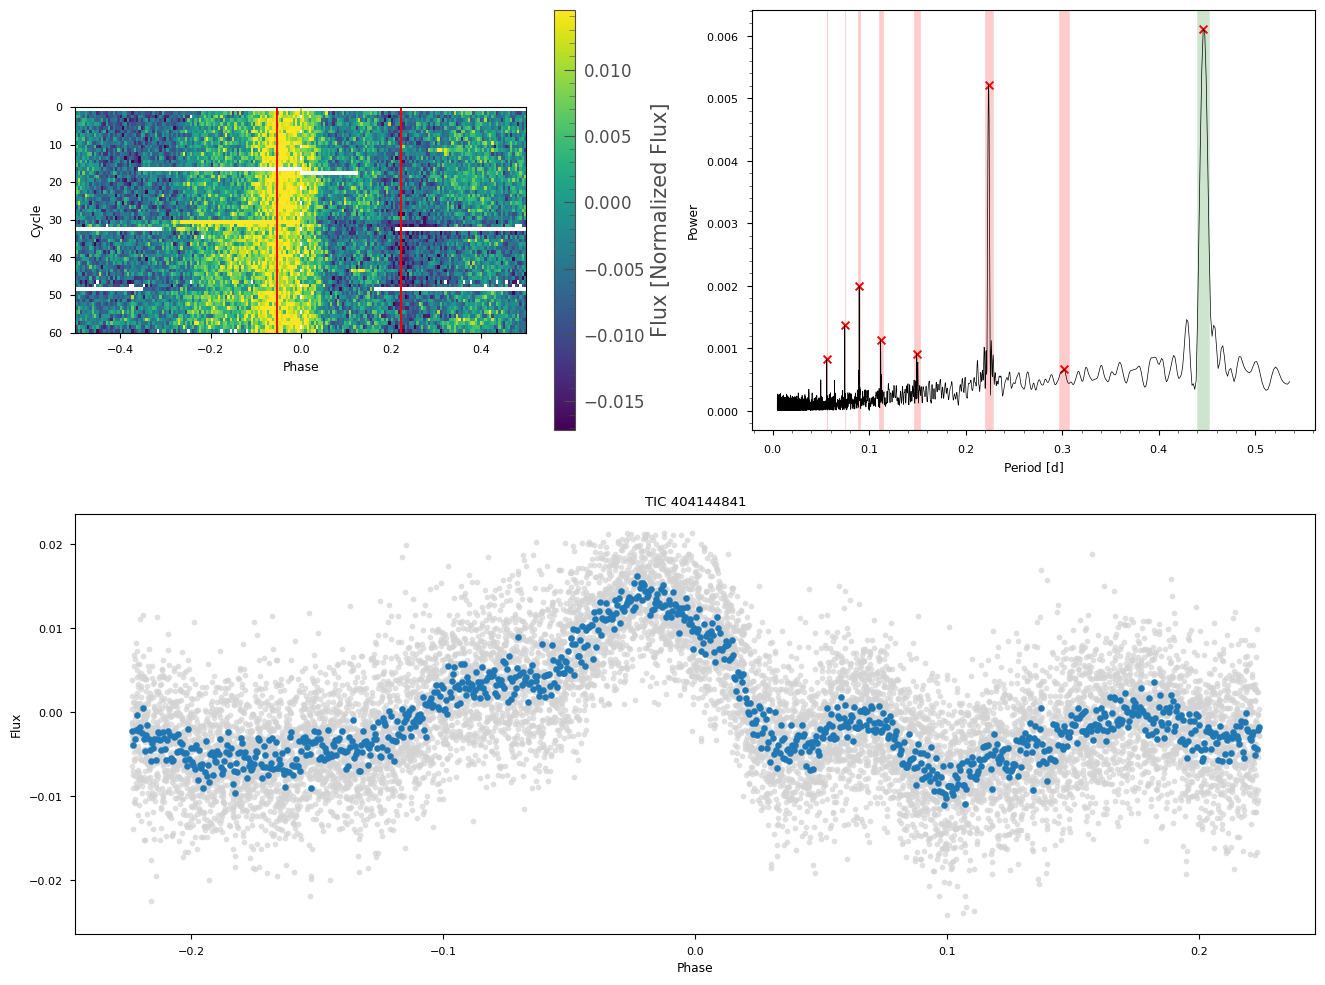

In [70]:
def multiplot(lc):
    fig, axs = plt.subplot_mosaic([
        ['tl', 'tr'],
        ['b', 'b']
    ], figsize=(16, 12))
    
    river_plot(lc, ax = axs["tl"])
    axs["tl"].set_title("")
    
    lombscargle(lc, ax = axs["tr"])
    axs["tr"].get_legend().remove()
    
    graph_lc_paper(lc, ax = axs["b"])

    return fig